In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

import copy

sys.path.insert(1, '../metadl/baselines/sentive_ai')
from sentive.sentive_vision_network import sentive_vision_network

from sentive.sentive_brain import sentive_brain

root_ep = 'episode_'
suf_eptest = '_1.csv'
root_test= 'test_'

episode = np.zeros([1,5,28,28,2])
test = np.zeros([5, 28,28,2])
for i in range(5):
    episode[0][i][:,:,0] = np.loadtxt(root_ep+str(i)+suf_eptest)
    episode[0][i][:,:,1] = np.loadtxt(root_ep+str(i)+suf_eptest)

    test[i][:,:,0] = np.loadtxt(root_test+str(i)+suf_eptest)
    test[i][:,:,1] = np.loadtxt(root_test+str(i)+suf_eptest)


nombre de neurones taille 1: 56
nombre de neurones taille 1: 81
nombre de neurones taille 1: 65
nombre de neurones taille 1: 80
nombre de neurones taille 1: 33


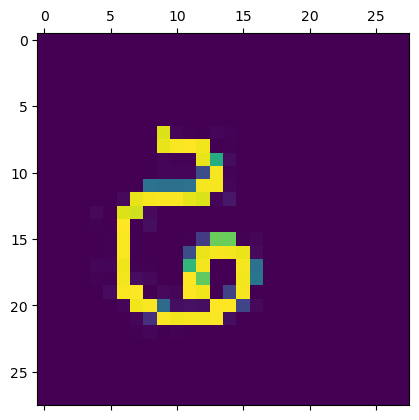

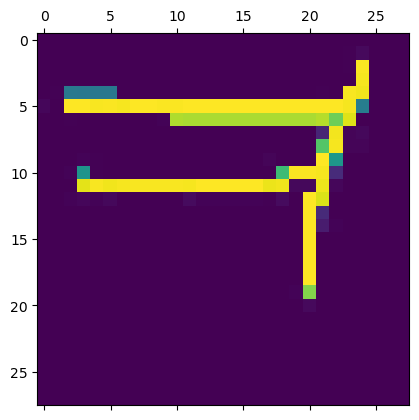

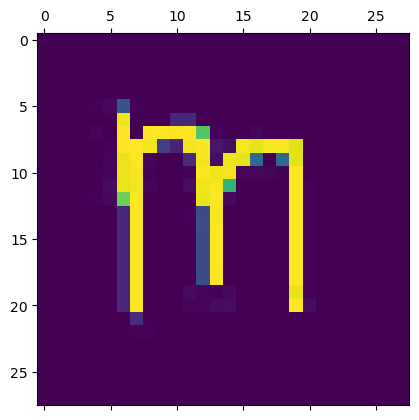

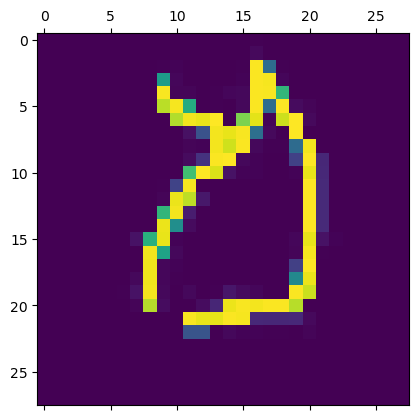

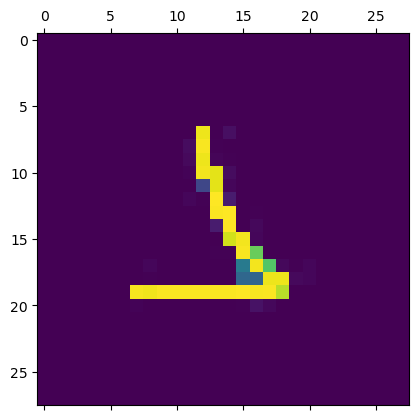

In [2]:
sbrain = sentive_brain(episode,5)

In [3]:
def compare_matrices(desired_mtrx, mtrx):
    if desired_mtrx.shape != mtrx.shape:
        raise ValueError("Les deux matrices n'ont pas la même forme")
    
    corr_matrix = np.corrcoef(desired_mtrx.flatten(), mtrx.flatten())
    similarity_score = np.abs(corr_matrix[0, 1]).mean()
    print(corr_matrix[0, 1])
    
    return similarity_score

In [4]:
def find_line(x1, y1, x2, y2):
    if x1 == x2:
        return (None, x1)
    elif y1 == y2:
        return (0, y1)
    else:
        a = (y2 - y1) / (x2 - x1)
        b = y1 - a * x1
        return (a, b)


def dot_on_line(x, y, a, b):
    return y == a * x + b

In [5]:
# to be removed                                                    
char_id = 0
self = sbrain.nnet[char_id]        
# to be removed 


##################################################
########## NEURONES DE LA COUCHE 2 (t_3) #########
##################################################
# Les neurones de cette couche ont des champs récepteurs 
# qui sont des matrices de *3x3* mais orientés

# copie locale de nrn_pxl_map
nrn_pxl_map = copy.deepcopy(self.nrn_pxl_map)

# Création de la nouvelle couche
self.nrn_tls.new_layer()
# liste contenant les id de la couche 2
lst_nrn2_pos = []

# on modifie les paramètres du neurone créé
# on crée des positions new_x et new_y vides pour le neurone
new_x = None
new_y = None

# Je crée une variable qui va contenir l'angle de rotation précédent
previous_angle_a_n2 = None

# initialisation de composants de décalage du vecteur de déplacement
shift_x = 0
shift_y = 0

# liste de nrn3 
lst_nrn3 = []

# liste de nrn3 coupled
list_coupled_nrn3s = []

bool_first_nrn2 = True

lst_nrn3_found = []

# boucle tant que new_x et new_y sont positifs ou vide:
def create_new_nrn3(self, lst_nrn3, nrn2, nrn_type="sentive_vision_curve"):
    nb3  = self.nrn_tls.add_new_nrn(nrn_type)

    # on ajoute le neurone à la liste des neurones de la couche 2
    lst_nrn3.append(nb3)
    # racourci pour accéder au neurone
    nrn3 = self.nrn_tls.lst_nrns[nb3].neuron

    # rendre le vecteur orientation du neurone 2 unitaire
    # norm_vecteur = np.sqrt(np.power(nrn2["meta"]["orientation"]["x"],2)+np.power(nrn2["meta"]["orientation"]["y"],2))

    key_nrn_type = "curve"

    if nrn_type == "sentive_vision_curve":
        key_nrn_type = "curve"

    elif nrn_type == "sentive_vision_line":
        key_nrn_type = "line"

    # maj du starting_point c'est le centre du nrn2
    nrn3["meta"][key_nrn_type]["starting_point"] = nrn2["meta"]["center"]
    # maj du vecteur de base
    # nrn3["meta"][key_nrn_type]["basis_vector"]["x"] = np.sqrt(2) * nrn2["meta"]["orientation"]["x"]/norm_vecteur
    # nrn3["meta"][key_nrn_type]["basis_vector"]["y"] = np.sqrt(2) * nrn2["meta"]["orientation"]["y"]/norm_vecteur
    nrn3["meta"][key_nrn_type]["basis_vector"]["x"] = nrn2["meta"]["orientation"]["x"]
    nrn3["meta"][key_nrn_type]["basis_vector"]["y"] = nrn2["meta"]["orientation"]["y"]
    nrn3["meta"][key_nrn_type]["nb_iteration"] = 1
    nrn3["meta"]["pending_nb_iteration"] = 1

    # on connecte le nrn2 au nrn3
    nrn3["DbConnectivity"]["pre_synaptique"].append(nrn2["_id"])

    '''
    # on lui ajoute les pixels
    mtrx = np.zeros([28,28])
    # boucle sur les neurones pixels présynaptiques du neurone 2
    for nrn_pxl_id in nrn2["DbConnectivity"]["pre_synaptique"]:
        if nrn_pxl_id > 0:
                # on récupère la matrice du neurone pixel
            mtrx = self.nrn_tls.get_neuron_receptive_field(nrn_pxl_id, mtrx)

        # on sauvegarde la matrice
    nrn3["meta"]["pixels_matrix"] = mtrx
    '''
    return lst_nrn3


def test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict):
    if nrn3_pos_predict["x"] - nrn2["meta"]["center"]["x"] > 1:
        nrn3_pos_predict["x"] = nrn2["meta"]["center"]["x"] + 1
    elif nrn3_pos_predict["x"] - nrn2["meta"]["center"]["x"] < -1:
        nrn3_pos_predict["x"] = nrn2["meta"]["center"]["x"] - 1
    if nrn3_pos_predict["y"] - nrn2["meta"]["center"]["y"] > 1:
        nrn3_pos_predict["y"] = nrn2["meta"]["center"]["y"] + 1
    elif nrn3_pos_predict["y"] - nrn2["meta"]["center"]["y"] < -1:
        nrn3_pos_predict["y"] = nrn2["meta"]["center"]["y"] - 1
    return nrn3_pos_predict

while new_x == None or new_y == None or (new_x > 0 and new_y > 0):
    # on crée un nouveau neurone de la couche 2
    nb  = self.nrn_tls.add_new_nrn()
    if bool_first_nrn2:
        # id minimum des neurones de la couche 2
        nb_min_nrn2 = copy.deepcopy(nb)
        bool_first_nrn2 = False
    # on ajoute le neurone à la liste des neurones de la couche 2
    lst_nrn2_pos.append(nb)
    # racourci pour accéder au neurone
    nrn2 = self.nrn_tls.lst_nrns[nb].neuron

    # si new_x et new_y sont vides on prend la position du premier neurone de la couche 1
    if new_x == None or new_y == None:
        new_x = self.nrn_tls.lst_nrns[0].neuron["meta"]["center"]["x"]
        nrn2["meta"]["center"]["x"] = new_x
        new_y = self.nrn_tls.lst_nrns[0].neuron["meta"]["center"]["y"]
        nrn2["meta"]["center"]["y"] = new_y
        nrn2["meta"]["matrix_width"] = 3
    else:
        nrn2["meta"]["center"]["x"] = new_x
        nrn2["meta"]["center"]["y"] = new_y
        nrn2["meta"]["matrix_width"] = 3
    print("\n\n______________________________________________________________________________________")
    print("nrn2 id", nrn2["_id"])
    print("new_x", new_x)
    print("new_y", new_y)
    # pixel central du neurone
    central_pixel_id = int(self.nrn_pxl_map[new_y][new_x])
    print("central_pixel_id", central_pixel_id)

    # supprime le pixel central de la map
    print("nrn_pxl_map[new_y][x]", nrn_pxl_map[new_y][new_x])
    nrn_pxl_map[new_y][new_x] = 0

    # tmp_sub_pxl_map contient les identifiants de chaque neurone pixel sur une carte nrnl_map
    tmp_sub_pxl_map = nrn_pxl_map[new_y - 1 : new_y + 2, new_x-1:new_x+2]
    print("tmp_sub_pxl_map :\n", tmp_sub_pxl_map)

    # si tmp_sub_pxl_map ne contient que des 0 on quitte la boucle
    if np.count_nonzero(tmp_sub_pxl_map) == 0:
        print("\n continue seulement des zéros\n")
        new_x = None
        new_y = None
        # vérifie si il reste des neurones pixels dans la map nrn_pxl_map
        if np.count_nonzero(nrn_pxl_map) == 0:
            print("\n break plus de neurones pixels\n")
            break
        else:
            print("\n continue il reste des neurones pixels\n")
            # trouve le premier neurone pixel dans la map
            for tmp_y in range(0, nrn_pxl_map.shape[0]):
                for tmp_x in range(0, nrn_pxl_map.shape[1]):
                    if nrn_pxl_map[tmp_y][tmp_x] > 0:
                        new_x = tmp_x
                        new_y = tmp_y
                        print("new_x", new_x)
                        print("new_y", new_y)
                        # pixel central du neurone
                        central_pixel_id = int(self.nrn_pxl_map[new_y][new_x])
                        nrn2["meta"]["center"]["x"] = new_x
                        nrn2["meta"]["center"]["y"] = new_y
                        nrn_pxl_map[new_y][new_x] = 0
                        # tmp_sub_pxl_map contient les identifiants de chaque neurone pixel sur une carte nrnl_map
                        tmp_sub_pxl_map = nrn_pxl_map[new_y - 1 : new_y + 2, new_x-1:new_x+2]
                        print("tmp_sub_pxl_map :\n", tmp_sub_pxl_map)
                        # initialisation de composants de décalage du vecteur de déplacement
                        shift_x = 0
                        shift_y = 0
                        break
                if new_x != None and new_y != None:
                    break

    nrn2["meta"]["sub_pxl_map"] = self.nrn_pxl_map[new_y-1:new_y+2, new_x-1:new_x+2]

    tmp_list_sub_pxl = list(set(tmp_sub_pxl_map.ravel()))
    # convertir tmp_list_sub_pxl en entiers
    tmp_list_sub_pxl = [int(i) for i in tmp_list_sub_pxl]

    # supprime les neurones pixels dans nrn_pxl_map qui sont dans le champ récepteur du neurone
    for tmp_y in range(new_y-1,new_y+2):
        for tmp_x in range(new_x-1,new_x+2):
            nrn_pxl_map[tmp_y][tmp_x] = 0

    #     ___      _         _        _   _          
    #    / _ \ _ _(_)___ _ _| |_ __ _| |_(_)___ _ _  
    #   | (_) | '_| / -_) ' \  _/ _` |  _| / _ \ ' \ 
    #    \___/|_| |_\___|_||_\__\__,_|\__|_\___/_||_|
    #                                                
    ## calcule le vecteur d'orientation moyen des pixels
    # pour chaque neurone pixel de la liste tmp_sub_pxl_map on calcule le vecteur d'orientation
    x_composant = []
    y_composant = []
    lst_nrn_pxl_pos = []
    mtrx_weights_pxl = np.zeros([3,3])
    weight_sum = 0
    # poids du pixel central
    mtrx_weights_pxl[1][1] = self.nrn_tls.lst_nrns[central_pixel_id-1].neuron["weight"] 

    print("tmp_list_sub_pxl", tmp_list_sub_pxl)
    for nrn_pxl_id in tmp_list_sub_pxl:
        if nrn_pxl_id > 0:
            print("nrn_pxl_id", nrn_pxl_id)
            # on récupère le neurone pixel
            nrn_pxl = self.nrn_tls.lst_nrns[nrn_pxl_id-1].neuron
            # on pondère par le poids du neurone pixel
            weight_sum += nrn_pxl["weight"]
            print("nrn_pxl id & weight :", nrn_pxl["_id"],nrn_pxl["weight"])
            # on récupère le vecteur d'orientation du neurone pixel
            x_composant.append(nrn_pxl["weight"]*(nrn_pxl["meta"]["center"]["x"] - nrn2["meta"]["center"]["x"]))
            y_composant.append(nrn_pxl["weight"]*(nrn_pxl["meta"]["center"]["y"] - nrn2["meta"]["center"]["y"]))
            # on met dans une liste les coordonnées des neurones pixels
            lst_nrn_pxl_pos.append(nrn_pxl["meta"]["center"])
            mtrx_weights_pxl[nrn_pxl["meta"]["center"]["y"] - nrn2["meta"]["center"]["y"] + 1][nrn_pxl["meta"]["center"]["x"] - nrn2["meta"]["center"]["x"] + 1] = nrn_pxl["weight"]

    # ajoute les id des neurones pixels dans la liste des pre_synaptique
    nrn2["DbConnectivity"]["pre_synaptique"] = tmp_list_sub_pxl
    # ajoute le neurone central dans la liste des pre_synaptique
    nrn2["DbConnectivity"]["pre_synaptique"].append(central_pixel_id)

    # on fait la moyenne des composantes
    print("x_composant", x_composant)
    x_composant = np.sum(x_composant)/weight_sum
    print("y_composant", y_composant)
    y_composant = np.sum(y_composant)/weight_sum
    print("vecteur orientation sans shift:",x_composant,y_composant)

    # on calcule le décalage du vecteur d'orientation
    # x_composant = x_composant - shift_x
    # y_composant = y_composant - shift_y
    # print("shift_x", shift_x)
    # print("shift_y", shift_y)
    # print("vecteur orientation AVEC shift:",x_composant,y_composant)
    # print("POSITION REELLE FINALE", new_x + x_composant, new_y + y_composant)
    desired_x = np.floor(new_x + x_composant)
    desired_y = np.floor(new_y + y_composant)

    # on sauvegarde le vecteur d'orientation
    nrn2["meta"]["orientation"] = {
        "x": x_composant,
        "y": y_composant
    }

    offset_x = np.round(x_composant)
    offset_y = np.round(y_composant)

    # calcul du décalage du vecteur d'orientation
    shift_x += x_composant - offset_x
    shift_y += y_composant - offset_y

    # calcul de la position du prochain neurone de la couche 2
    new_new_x = int(np.ceil(nrn2["meta"]["center"]["x"] + offset_x))
    new_new_y = int(np.ceil(nrn2["meta"]["center"]["y"] + offset_y))

    if new_new_x != new_x or new_new_y != new_y:
        new_x = new_new_x
        new_y = new_new_y
        print("PROCHAIN NEURONE: [new_x:", new_x, ", new_y:", new_y, "]")
    else:
        if x_composant < 0:
            print("x_composant < 0")
            print("x_composant", x_composant)
            print("np.floor(x_composant)", np.floor(x_composant))
            new_x = int(np.round(nrn2["meta"]["center"]["x"] + np.floor(x_composant)))
        else:
            print("x_composant > 0")
            print("x_composant", x_composant)
            print("np.ceil(x_composant)", np.ceil(x_composant))
            new_x = int(np.round(nrn2["meta"]["center"]["x"] + np.ceil(x_composant)))
        if y_composant < 0:
            new_y = int(np.round(nrn2["meta"]["center"]["y"] + np.floor(y_composant)))
        else:
            new_y = int(np.round(nrn2["meta"]["center"]["y"] + np.ceil(y_composant)))

    print("PROCHAIN NEURONE SANS CHANGEMENT: [new_x:", new_x, ", new_y:", new_y, "]")
    print("mtrx_weights_pxl:\n", mtrx_weights_pxl)
    # prochain neurone new_x et new_y dans les coordonnées de mtrx_weights_pxl
    print("neurone a supprimer dans la matrice : x :", new_x - nrn2["meta"]["center"]["x"] + 1, "y:", new_y - nrn2["meta"]["center"]["y"] + 1)

    # on supprime le neurone suivant de la matrice afin de calculer un poids des neurones de base
    mtrx_weights_pxl[new_y - nrn2["meta"]["center"]["y"] + 1][new_x - nrn2["meta"]["center"]["x"] + 1] = 0
    print("mtrx_weights_pxl:\n", mtrx_weights_pxl)

    # calcul des coordonnées du barycentre de la mtrx_weights_pxl
    # on calcule le barycentre de la matrice
    barycentre = np.zeros([2])
    for y in range(0,3):
        for x in range(0,3):
            barycentre[0] += x * mtrx_weights_pxl[y][x]
            barycentre[1] += y * mtrx_weights_pxl[y][x]

    barycentre[0] = barycentre[0] / np.sum(mtrx_weights_pxl)
    barycentre[1] = barycentre[1] / np.sum(mtrx_weights_pxl)
    print("barycentre", barycentre)

    # on vérifie que le neurone est dans la carte
    if new_x < 0 or new_x >= self.nrn_pxl_map.shape[1] or new_y < 0 or new_y >= self.nrn_pxl_map.shape[0]:
        print("\nNeurone hors de la carte")
        new_x = -1
        new_y = -1

    #                      _____  
    #                     |____ | 
    #   _ __  _ __ _ __       / / 
    #  | '_ \| '__| '_ \      \ \ 
    #  | | | | |  | | | | .___/ / 
    #  |_| |_|_|  |_| |_| \____/  
    #                             
    #                                                 
    # variable bool qui sert à savoir si on a trouvé un neurone valide de la couche 3              
    nrn3_not_found = True
    nrn3_curve_not_found = True

    # diretions détectées 
    new_pixels_detected = []

    # liste temporaire des neurones nrn3 trouvés
    tmp_lst_nrn3_found = []
    
    # boucle sur chaque nrn3 dans la liste :
    for nb3 in lst_nrn3:
        # racourci pour accéder au neurone
        nrn3 = self.nrn_tls.lst_nrns[nb3].neuron

        #                    ____  _ _          
        #    _ _  _ _ _ _   |__ / | (_)_ _  ___ 
        #   | ' \| '_| ' \   |_ \ | | | ' \/ -_)
        #   |_||_|_| |_||_| |___/ |_|_|_||_\___|
        #                                       
        # si le nrn3 est une ligne :
        if nrn3["type"] == "sentive_vision_line":
            print("******************")
            print("nrn3", nrn3["_id"], "est une ligne")
            # on récupère le basis_vector du neurone 3
            basis_vector = nrn3["meta"]["line"]["basis_vector"]
            # on calcul la norme du basis vector
            norm_basis_vector = np.sqrt(np.power(basis_vector["x"],2)+np.power(basis_vector["y"],2))
            # on normalise le basis_vector
            if norm_basis_vector != 0:
                basis_vector = {
                        "x": basis_vector["x"] / norm_basis_vector,
                        "y": basis_vector["y"] / norm_basis_vector
                }

            # on récupère le starting_point du neurone 3
            starting_point = nrn3["meta"]["line"]["starting_point"]

            # on fait une boucle jusqu'à ce qu'on trouve la position actuelle. Si la distance augmente on sort de la boucle.
            # on initialise la distance entre le starting_point et la position actuelle
            distance = np.sqrt(np.power(starting_point["x"] - nrn2["meta"]["center"]["x"],2)+np.power(starting_point["y"] - nrn2["meta"]["center"]["y"],2))
            print("distance initiale:", distance)
            min_distance = copy.deepcopy(distance)

            # on initialise le new_point
            new_point = copy.deepcopy(starting_point)
            # compteur de boucle
            i = 0
            # boucle qui s'arrête si la distance augmente ou si elle devient inférieure à 1
            while distance == min_distance :
                # détermination du new_point
                new_point = {
                    "x": new_point["x"] + basis_vector["x"],
                    "y": new_point["y"] + basis_vector["y"]
                }
                # calcul de la distance entre le new_point et le nrn2["meta"]["center"]
                distance = np.sqrt(np.power(new_point["x"] - nrn2["meta"]["center"]["x"],2)+np.power(new_point["y"] - nrn2["meta"]["center"]["y"],2))
                # on incrémente le compteur de boucle
                i += 1
                # on M.A.J. la distance minimale
                if distance < min_distance:
                    min_distance = copy.deepcopy(distance)
                if distance < 1:
                    break
                if i > 100:
                    break

            # on affiche le nombre de boucle et le new_point
            print("nombre de boucle:", i, ", new_point:", new_point, ", center", nrn2["meta"]["center"])
            print("* distance finale:", distance, ', (min_distance:', min_distance, ')')
            
            pos_predict = []
            # si la distance est nulle, on peut faire une prédiction
            if distance < 1:
                nrn3_pos_predict = {
                    "x": np.floor(new_point["x"] + basis_vector["x"]),
                    "y": np.floor(new_point["y"] + basis_vector["y"])
                }
                pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                nrn3_pos_predict = {
                    "x": np.round(new_point["x"] + basis_vector["x"]),
                    "y": np.round(new_point["y"] + basis_vector["y"])
                }
                pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                nrn3_pos_predict = {
                    "x": np.ceil(new_point["x"] + basis_vector["x"]),
                    "y": np.ceil(new_point["y"] + basis_vector["y"])
                }
                pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                nrn3_pos_predict = {
                    "x": np.floor(new_point["x"] + 1.5 * basis_vector["x"]),
                    "y": np.floor(new_point["y"] + 1.5 * basis_vector["y"])
                }
                pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                nrn3_pos_predict = {
                    "x": np.round(new_point["x"] + 1.5 * basis_vector["x"]),
                    "y": np.round(new_point["y"] + 1.5 * basis_vector["y"])
                }
                pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                nrn3_pos_predict = {
                    "x": np.ceil(new_point["x"] + 1.5 * basis_vector["x"]),
                    "y": np.ceil(new_point["y"] + 1.5 * basis_vector["y"])
                }
                pos_predict.append(copy.deepcopy(nrn3_pos_predict))
            else:
                nrn3_pos_predict = {
                    "x": np.floor(new_point["x"]),
                    "y": np.floor(new_point["y"])
                }
                pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                nrn3_pos_predict = {
                    "x": np.round(new_point["x"]),
                    "y": np.round(new_point["y"])
                }
                pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                new_point = {
                    "x": new_point["x"] - basis_vector["x"],
                    "y": new_point["y"] - basis_vector["y"]
                }
            
            # alternative 1
            nrn3_pos_predict = {
                "x": np.floor(pos_predict[0]["x"] - basis_vector["y"]),
                "y": np.floor(pos_predict[0]["y"] + basis_vector["x"])
            }
            pos_predict.append(copy.deepcopy(nrn3_pos_predict))
            nrn3_pos_predict = {
                "x": np.round(pos_predict[0]["x"] - basis_vector["y"]),
                "y": np.round(pos_predict[0]["y"] + basis_vector["x"])
            }
            pos_predict.append(copy.deepcopy(nrn3_pos_predict))
            # alternative 2
            nrn3_pos_predict = {
                "x": np.floor(pos_predict[0]["x"] + basis_vector["y"]),
                "y": np.floor(pos_predict[0]["y"] - basis_vector["x"])
            }
            pos_predict.append(copy.deepcopy(nrn3_pos_predict))
            nrn3_pos_predict = {
                "x": np.round(pos_predict[0]["x"] + basis_vector["y"]),
                "y": np.round(pos_predict[0]["y"] - basis_vector["x"])
            }
            pos_predict.append(copy.deepcopy(nrn3_pos_predict))
            
            print("LINE pos_predict:", pos_predict)

            ###############################################
            # Comparaison des pixels alentours avec les pixels prédits
            ###############################################
            tmp_new_pixels_detected = {}
            tmp_angle_min = -999
            is_found = False
            orientation = None

            for coord_pixel in lst_nrn_pxl_pos:
                test_x = coord_pixel["x"]
                test_y = coord_pixel["y"]
                for nrn3_pos_predicted in pos_predict:
                    if abs(nrn3_pos_predicted["x"] - test_x) < 1 and abs(nrn3_pos_predicted["y"] - test_y) < 1:
                        is_found = True
                        
                        tmp_orientation = {
                            "x": test_x - new_point["x"],
                            "y": test_y - new_point["y"]
                        }
                        '''
                        orientation = {
                            "x": test_x - nrn2["meta"]["center"]["x"],
                            "y": test_y - nrn2["meta"]["center"]["y"]
                        }
                        '''
                        # calcul l'angle entre l'orientation et le vecteur de base
                        tmp_angle = np.abs(self.nrn_tls.calc_angle(tmp_orientation, basis_vector))

                        if tmp_angle_min == -999 or tmp_angle < tmp_angle_min:
                            orientation = copy.deepcopy(tmp_orientation)
                            tmp_angle_min = tmp_angle
                            tmp_new_pixels_detected = {
                                "x": test_x,
                                "y": test_y,
                                "nb_iteration": nrn3["meta"]["line"]["nb_iteration"],
                                "neuron_type": nrn3["type"],
                                "distance": copy.deepcopy(min_distance),
                                "angle": copy.deepcopy(tmp_angle)
                            }
                            print("__>")
                            print("tmp_new_pixels_detected", tmp_new_pixels_detected)
                            print("nrn3 pos found", nrn3_pos_predicted)
                            print("angle", tmp_angle)
                            print("<__")
                        
            if is_found:
                new_pixels_detected.append(copy.deepcopy(tmp_new_pixels_detected))

            if is_found and orientation is not None and min_distance < 1.5:
                # tmp_lst_nrn3_found.append(nrn3["_id"])
                # normalisation de l'orientation
                orientation["x"] = orientation["x"] / np.sqrt(np.power(orientation["x"],2)+np.power(orientation["y"],2))
                orientation["y"] = orientation["y"] / np.sqrt(np.power(orientation["x"],2)+np.power(orientation["y"],2))

                # nrn3["meta"]["line"]["nb_iteration"] += 1
                nrn3["meta"]["pending_nb_iteration"] += 1
                print("nrn3 ligne trouvé !!!!!!!!!!!!!")
                # je vais faire une moyenne itérative avec la basis_vector du neurone 3
                # je récupère le basis_vector du neurone 3
                print("basis_vector AVANT", nrn3["meta"]["line"]["basis_vector"])
                tmp_bsvct = copy.deepcopy(nrn3["meta"]["line"]["basis_vector"])
                # nombre d'itération
                n = nrn3["meta"]["line"]["nb_iteration"] + 1
                # je calcule la moyenne itérative

                nrn3_basis_vector_new_tmp = {
                    "x": self.nrn_tls.FctIterMean(n, orientation["x"], nrn3["meta"]["line"]["basis_vector"]["x"] ),
                    "y": self.nrn_tls.FctIterMean(n, orientation["y"], nrn3["meta"]["line"]["basis_vector"]["y"] )
                }
                # nrn3["meta"]["line"]["basis_vector"]["x"] = self.nrn_tls.FctIterMean(n, orientation["x"], nrn3["meta"]["line"]["basis_vector"]["x"] ) 
                # nrn3["meta"]["line"]["basis_vector"]["y"] = self.nrn_tls.FctIterMean(n, orientation["y"], nrn3["meta"]["line"]["basis_vector"]["y"] )

                print("--> nouvelle orientation", orientation)
                # calc_angle de l'ancien et du nouveau basis_vector
                tmp_angle_bsvct = self.nrn_tls.calc_angle(tmp_bsvct, nrn3_basis_vector_new_tmp)
                print("basis_vector APRES", nrn3["meta"]["line"]["basis_vector"], "(angle avant et après:", tmp_angle_bsvct, ")")
                
                # calculer l'angle max possible             
                tmp_angle_max = 2 * np.arccos(n/np.sqrt(np.power(n,2)+np.power(1,2)))
                print("tmp_angle_max ", tmp_angle_max)
                # si tmp_angle_max >= tmp_angle_bsvct + nrn3["meta"]["cumulated_angle"] alors on valide la ligne
                if tmp_angle_max >= tmp_angle_bsvct + nrn3["meta"]["cumulated_angle"]:
                    nrn3["meta"]["line"]["nb_iteration"] += 1
                    nrn3["meta"]["cumulated_angle"] += tmp_angle_bsvct
                    # ajout de l'id du nrn2 dans presynaptic DbConnectivity': {'pre_synaptique
                    nrn3["DbConnectivity"]["pre_synaptique"].append(nrn2["_id"])
                    # ajout de l'id du nrn3 dans postsynaptic DbConnectivity': {'post_synaptique
                    nrn2["DbConnectivity"]["post_synaptique"].append(nrn3["_id"])
                    # sauvegarde du basis_vector
                    nrn3["meta"]["line"]["basis_vector"] = nrn3_basis_vector_new_tmp
                    print("angle OK pour sauvegarder ")
                    # finalement on sauvegarde pas
                    nrn3_not_found = False
            else:
                nrn3["meta"]["nb_points_aligned"] = 0
                nrn3["meta"]["pending_nb_iteration"] += 1

        #                  ____                  _ 
        #    _ _  _ _ _ _ |__ /  __ ___ _  _ _ _| |__  ___ ___
        #   | ' \| '_| ' \ |_ \ / _/ _ \ || | '_| '_ \/ -_|_-<
        #   |_||_|_| |_||_|___/ \__\___/\_,_|_| |_.__/\___/__/
        #                                       
        # 
        elif nrn3["type"] == "sentive_vision_curve":
            print("\n******************")
            print("nrn3", nrn3["_id"], "est une courbe")
            print(nrn3["meta"]["curve"]["basis_vector"], "basis_vector")
            print("nrn3", nrn3["_id"], "nb_iteration", nrn3["meta"]["curve"]["nb_iteration"])
            # angle
            print("nrn3", nrn3["_id"], "angle", nrn3["meta"]["curve"]["angle"])
                     
            if nrn3["meta"]["curve"]["nb_iteration"] == 1:
                # je récupère le vecteur d'orientation du neurone 2
                orientation = nrn2["meta"]["orientation"]
                # je récupère le basis_vector du neurone 3
                basis_vector = nrn3["meta"]["curve"]["basis_vector"]
                # je calcule l'angle entre le basis_vector et l'orientation
                angle = self.nrn_tls.calc_angle(basis_vector, orientation)
                print("found angle", angle)
                # je sauvegarde la valeur d'angle dans nrn3
                nrn3["meta"]["curve"]["angle"] = angle
                #  je met le compteur nb_d'itération à 2.
                nrn3["meta"]["curve"]["nb_iteration"] = 2
                nrn3["meta"]["pending_nb_iteration"] += 1
                # Je sauvegarde le vecteur d'orientation de nrn2 dans last_vector.
                nrn3["meta"]["curve"]["last_vector"] = nrn2["meta"]["orientation"]
                nrn3_not_found = False
                nrn3_curve_not_found = False
                # ajout de l'id du nrn2 dans presynaptic DbConnectivity': {'pre_synaptique
                nrn3["DbConnectivity"]["pre_synaptique"].append(nrn2["_id"])
                # ajout de l'id du nrn3 dans postsynaptic DbConnectivity': {'post_synaptique
                nrn2["DbConnectivity"]["post_synaptique"].append(nrn3["_id"])

            # Si le nombre d'itération est > 1  alors je calcule l'angle entre le basis_vector et l'angle d'orientation du nrn2,
            elif nrn3["meta"]["curve"]["nb_iteration"] >= 2 and nrn3["meta"]["pending_nb_iteration"] == nrn3["meta"]["curve"]["nb_iteration"]:
                nrn3["meta"]["pending_nb_iteration"] += 1

                # on récupère le starting_point du neurone 3
                starting_point = nrn3["meta"]["curve"]["starting_point"]

                # on récupère le basis_vector du neurone 3
                basis_vector = copy.deepcopy(nrn3["meta"]["curve"]["basis_vector"])

                # on fait une boucle jusqu'à ce qu'on trouve la position actuelle. Si la distance augmente on sort de la boucle.
                # on initialise la distance entre le starting_point et la position actuelle
                distance = np.sqrt(np.power(starting_point["x"] - nrn2["meta"]["center"]["x"],2)+np.power(starting_point["y"] - nrn2["meta"]["center"]["y"],2))
                print("distance initiale:", distance)
                min_distance = copy.deepcopy(distance)

                # on initialise le new_point
                new_point = copy.deepcopy(starting_point)
                # compteur de boucle
                i = 0
                # boucle qui s'arrête si la distance augmente ou si elle devient inférieure à 1
                while distance == min_distance :
                    if i > 0:
                        # rotation du basis vector (pas tout de suite)
                        basis_vector = self.nrn_tls.draw_rotate_vector(basis_vector, nrn3["meta"]["curve"]["angle"])
                        print("new direction basis vector", basis_vector)

                    # détermination du new_point
                    new_point = {
                        "x": new_point["x"] + basis_vector["x"],
                        "y": new_point["y"] + basis_vector["y"]
                    }
                    print("new point", new_point)

                    # calcul de la distance entre le new_point et le nrn2["meta"]["center"]
                    distance = np.sqrt(np.power(new_point["x"] - nrn2["meta"]["center"]["x"],2)+np.power(new_point["y"] - nrn2["meta"]["center"]["y"],2))
                    print("distance:", distance)
                    # on incrémente le compteur de boucle
                    i += 1
                    # on M.A.J. la distance minimale
                    if distance < min_distance:
                        min_distance = copy.deepcopy(distance)
                    if distance < 1:
                        break
                    if i > 100:
                        break


                ###############################################
                # on affiche le nombre de boucle et le new_point
                print("CURVED nombre de boucles:", i, ", new_point:", new_point, ", center", nrn2["meta"]["center"])
                print("* distance finale:", distance, ', (min_distance:', min_distance, ')')
                

                #  |)   _  |. _|-.  ,_
                #  | |`(/_(||(_|_|()||
                # 
                
                check_predict = True
                while check_predict:
                    pos_predict = []
                    # si la distance est nulle, on peut faire une prédiction
                    if distance < 1:
                        vector_predicted = self.nrn_tls.draw_rotate_vector(basis_vector, nrn3["meta"]["curve"]["angle"])
                        nrn3_pos_predict = {
                            "x": np.floor(new_point["x"] + vector_predicted["x"]),
                            "y": np.floor(new_point["y"] + vector_predicted["y"])
                        }
                        # calcule entre la position prédite et le nrn2["meta"]["center"]
                        distance = np.sqrt(np.power(nrn3_pos_predict["x"] - nrn2["meta"]["center"]["x"],2)+np.power(nrn3_pos_predict["y"] - nrn2["meta"]["center"]["y"],2))
                        nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                        pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                        nrn3_pos_predict = {
                            "x": np.round(new_point["x"] + vector_predicted["x"]),
                            "y": np.round(new_point["y"] + vector_predicted["y"])
                        }
                        nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                        pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                        nrn3_pos_predict = {
                            "x": np.ceil(new_point["x"] + vector_predicted["x"]),
                            "y": np.ceil(new_point["y"] + vector_predicted["y"])
                        }
                        nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                        pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                        nrn3_pos_predict = {
                            "x": np.floor(new_point["x"] + 1.5 * vector_predicted["x"]),
                            "y": np.floor(new_point["y"] + 1.5 * vector_predicted["y"])
                        }
                        nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                        pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                        nrn3_pos_predict = {
                            "x": np.round(new_point["x"] + 1.5 * vector_predicted["x"]),
                            "y": np.round(new_point["y"] + 1.5 * vector_predicted["y"])
                        }
                        nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                        pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                        nrn3_pos_predict = {
                            "x": np.ceil(new_point["x"] + 1.5 * vector_predicted["x"]),
                            "y": np.ceil(new_point["y"] + 1.5 * vector_predicted["y"])
                        }
                        nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                        pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                    else: # sinon on fait une prédiction sur la position du new_point (dépassement de la position de distance minimale)
                        nrn3_pos_predict = {
                            "x": np.floor(new_point["x"]),
                            "y": np.floor(new_point["y"])
                        }
                        nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                        pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                        nrn3_pos_predict = {
                            "x": np.round(new_point["x"]),
                            "y": np.round(new_point["y"])
                        }
                        nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                        pos_predict.append(copy.deepcopy(nrn3_pos_predict))

                        # Je recule d'un élément car dans ce cas, cela signifie qu'on a dépassé la position de distance minimale
                        new_point = {
                            "x": new_point["x"] - basis_vector["x"],
                            "y": new_point["y"] - basis_vector["y"]
                        }
                        vector_predicted = copy.deepcopy(basis_vector)
                        basis_vector = self.nrn_tls.draw_rotate_vector(basis_vector, -nrn3["meta"]["curve"]["angle"])
                    
                    # alternative 1
                    nrn3_pos_predict = {
                        "x": np.floor(pos_predict[0]["x"] - vector_predicted["y"]),
                        "y": np.floor(pos_predict[0]["y"] + vector_predicted["x"])
                    }
                    nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                    pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                    nrn3_pos_predict = {
                        "x": np.round(pos_predict[0]["x"] - vector_predicted["y"]),
                        "y": np.round(pos_predict[0]["y"] + vector_predicted["x"])
                    }
                    nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                    pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                    # alternative 2
                    nrn3_pos_predict = {
                        "x": np.floor(pos_predict[0]["x"] + vector_predicted["y"]),
                        "y": np.floor(pos_predict[0]["y"] - vector_predicted["x"])
                    }
                    nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                    pos_predict.append(copy.deepcopy(nrn3_pos_predict))
                    nrn3_pos_predict = {
                        "x": np.round(pos_predict[0]["x"] + vector_predicted["y"]),
                        "y": np.round(pos_predict[0]["y"] - vector_predicted["x"])
                    }
                    nrn3_pos_predict = test_pos_predict_on_3x3_grid(nrn2, nrn3_pos_predict)
                    pos_predict.append(copy.deepcopy(nrn3_pos_predict))

                    print("CURVE vector_predicted", vector_predicted)
                    print("CURVE pos_predict:", pos_predict)
                    print("========================")
                    print("CURVE nrn3 id",nrn3["_id"] , "CURVE position", nrn3["meta"]["curve"]["nb_iteration"], "->", nrn3["meta"]["curve"]["nb_iteration"] + 1)
                    print("========================")

                    
                    ###############################################################
                    # comparer les positions prédites avec chacune des positions des neurones pixels dans la liste lst_nrn_pxl_pos
                    tmp_new_pixels_detected = {}
                    tmp_angle_min = -999
                    tmp_angle_min_alt2 = -999
                    test_angle_min = -999
                    is_found = False
                    orientation = None
                    for coord_pixel in lst_nrn_pxl_pos:
                        test_x = coord_pixel["x"]
                        test_y = coord_pixel["y"]
                        for nrn3_pos_predicted in pos_predict:
                            if abs(nrn3_pos_predicted["x"] - test_x) < 1 and abs(nrn3_pos_predicted["y"] - test_y) < 1:
                                is_found = True

                                tmp_orientation = {
                                    "x": test_x - new_point["x"],
                                    "y": test_y - new_point["y"]
                                }
                                tmp_orientation_alt2 = {
                                    "x": test_x - nrn2["meta"]["center"]["x"],
                                    "y": test_y - nrn2["meta"]["center"]["y"]
                                }
                                tmp_angle = self.nrn_tls.calc_angle(basis_vector, tmp_orientation)
                                test_angle = np.abs(self.nrn_tls.calc_angle(vector_predicted, tmp_orientation))
                                tmp_angle_alt2 = self.nrn_tls.calc_angle(basis_vector, tmp_orientation_alt2)
                                print("CURVE tmp_orientation", tmp_orientation)
                                print("CURVE vector_predicted", vector_predicted)
                                print("CURVE tmp_angle", tmp_angle)
                                print("CURVE test_angle", test_angle)
                                if test_angle_min == -999 or test_angle < test_angle_min:
                                    test_angle_min = test_angle
                                    orientation = copy.deepcopy(tmp_orientation)
                                    tmp_angle_min = tmp_angle
                                    tmp_angle_min_alt2 = tmp_angle_alt2
                                    tmp_new_pixels_detected = {
                                        "x": test_x,
                                        "y": test_y,
                                        "nb_iteration": nrn3["meta"]["curve"]["nb_iteration"],
                                        "neuron_type": nrn3["type"],
                                        "distance" : copy.deepcopy(min_distance),
                                        "angle" : self.nrn_tls.calc_angle(tmp_orientation, vector_predicted)
                                    }
                                    print("__>")
                                    print("CURVED tmp_new_pixels_detected", tmp_new_pixels_detected)
                                    print("nrn3 pos found", nrn3_pos_predicted)
                                    print("angle", tmp_angle)
                                    print("<__")
                    if is_found:
                        new_pixels_detected.append(copy.deepcopy(tmp_new_pixels_detected))
                        check_predict = False
                    else:
                        if distance < 1:
                            new_point = {
                                "x": new_point["x"] + vector_predicted["x"],
                                "y": new_point["y"] + vector_predicted["y"]
                            }
                            # calcule entre la position prédite et le nrn2["meta"]["center"]
                            distance = np.sqrt(np.power(nrn3_pos_predict["x"] - nrn2["meta"]["center"]["x"],2)+np.power(nrn3_pos_predict["y"] - nrn2["meta"]["center"]["y"],2))
                            print("check_predict distance:", distance, "min_distance:", min_distance, "new_point:", new_point)
                            if distance < min_distance:
                                min_distance = copy.deepcopy(distance)
                                check_predict = True
                            else:
                                check_predict = False
                        else:
                            check_predict = False

                if is_found and orientation is not None and min_distance < 1.5:
                    tmp_lst_nrn3_found.append(nrn3["_id"])
                    nrn3_not_found = False
                    nrn3_curve_not_found = False
                    print("Prédiction nrn3 CURVE", nrn3["_id"], "TROUVé")
                    print("************************************")
                    nrn3["meta"]["curve"]["nb_iteration"] += 1
                    # mettre à jour l'angle
                    # angle = self.nrn_tls.calc_angle(nrn3["meta"]["curve"]["last_vector"], orientation)
                    
                    print("vecteur d'orientation Choisi", orientation)
                    print("nouvel angle mesuré", tmp_angle_min, "(alt2 centre:", tmp_angle_min_alt2, ")")
                    angle = self.nrn_tls.FctIterMean(nrn3["meta"]["curve"]["nb_iteration"], tmp_angle_min, nrn3["meta"]["curve"]["angle"])
                    print("nb itérations:", nrn3["meta"]["curve"]["nb_iteration"])
                    print("=== angle M.à.J.", angle, "===")
                    # je sauvegarde la valeur d'angle dans nrn3
                    nrn3["meta"]["curve"]["angle"] = angle
                    # Je sauvegarde le vecteur d'orientation de nrn2 dans last_vector.
                    nrn3["meta"]["curve"]["last_vector"] = orientation
                    # ajout de l'id du nrn2 dans presynaptic DbConnectivity': {'pre_synaptique
                    nrn3["DbConnectivity"]["pre_synaptique"].append(nrn2["_id"])
                    # ajout de l'id du nrn3 dans postsynaptic DbConnectivity': {'post_synaptique
                    nrn2["DbConnectivity"]["post_synaptique"].append(nrn3["_id"])

    # si on a pas trouvé de neurone de la couche 3 valide on en crée un nouveau
    # un nrn ligne
    if nrn3_not_found:
        # je crée un couple de neurone de la couche 3, un neurone ligne et un neurone courbe
        # le neurone courbe :
        lst_nrn3 = create_new_nrn3(self, lst_nrn3, nrn2)
        new_nrn3_curve = self.nrn_tls.lst_nrns[lst_nrn3[-1]].neuron
        tmp_dx = barycentre[0] - 1
        tmp_dy = barycentre[1] - 1
        
        new_nrn3_curve["meta"]["curve"]["starting_point"]["x"] =  nrn2["meta"]["center"]["x"] + tmp_dx
        new_nrn3_curve["meta"]["curve"]["starting_point"]["y"] =  nrn2["meta"]["center"]["y"] + tmp_dy
        new_nrn3_curve["meta"]["curve"]["basis_vector"]["x"] -= tmp_dx
        new_nrn3_curve["meta"]["curve"]["basis_vector"]["y"] -= tmp_dy
        # normaliser le basis_vector
        new_nrn3_curve["meta"]["curve"]["basis_vector"]["x"] = new_nrn3_curve["meta"]["curve"]["basis_vector"]["x"] / np.sqrt(np.power(new_nrn3_curve["meta"]["curve"]["basis_vector"]["x"],2)+np.power(new_nrn3_curve["meta"]["curve"]["basis_vector"]["y"],2))
        new_nrn3_curve["meta"]["curve"]["basis_vector"]["y"] = new_nrn3_curve["meta"]["curve"]["basis_vector"]["y"] / np.sqrt(np.power(new_nrn3_curve["meta"]["curve"]["basis_vector"]["x"],2)+np.power(new_nrn3_curve["meta"]["curve"]["basis_vector"]["y"],2))
        print("###############################")
        print("nrn3", new_nrn3_curve["_id"])
        print("tmp_dx, tmp_dy", tmp_dx, tmp_dy)
        print("basis_vector", new_nrn3_curve["meta"]["curve"]["basis_vector"])
        # Ajouter la dbconnectivity
        for previous_nrn3_id in lst_nrn3_found:
            previous_nrn3 = self.nrn_tls.lst_nrns[previous_nrn3_id-1].neuron
            new_nrn3_curve["DbConnectivity"]["anti_lateral"].append(previous_nrn3["_id"])
            previous_nrn3["DbConnectivity"]["lateral_connexion"].append(new_nrn3_curve["_id"])

        # le neurone ligne :
        lst_nrn3 = create_new_nrn3(self, lst_nrn3, nrn2, "sentive_vision_line")
        new_nrn3_2 = self.nrn_tls.lst_nrns[lst_nrn3[-1]].neuron
        print("###############################")
        print("nrn3", new_nrn3_2["_id"])

        # ajouter l'id du neurone courbe dans la liste des neurones connectés post-synaptique du neurone ligne
        new_nrn3_2["DbConnectivity"]["post_synaptique"].append(new_nrn3_curve["_id"])

        # list_coupled_nrn3s.append([new_nrn3_curve["_id"], new_nrn3_2["_id"]])

    elif nrn3_curve_not_found:
         # le neurone courbe :
        lst_nrn3 = create_new_nrn3(self, lst_nrn3, nrn2)
        new_nrn3 = self.nrn_tls.lst_nrns[lst_nrn3[-1]].neuron
        tmp_dx = barycentre[0] - 1
        tmp_dy = barycentre[1] - 1
        new_nrn3["meta"]["curve"]["starting_point"]["x"] =  nrn2["meta"]["center"]["x"] + tmp_dx
        new_nrn3["meta"]["curve"]["starting_point"]["y"] =  nrn2["meta"]["center"]["y"] + tmp_dy
        # new_nrn3["meta"]["curve"]["basis_vector"]["x"] += tmp_dx
        # new_nrn3["meta"]["curve"]["basis_vector"]["y"] += tmp_dy
        print("###############################")
        print("nrn3", new_nrn3["_id"])
        # Ajouter la dbconnectivity
        for previous_nrn3_id in lst_nrn3_found:
            previous_nrn3 = self.nrn_tls.lst_nrns[previous_nrn3_id-1].neuron
            new_nrn3["DbConnectivity"]["anti_lateral"].append(previous_nrn3["_id"])
            previous_nrn3["DbConnectivity"]["lateral_connexion"].append(new_nrn3["_id"])

    # liste des neurones nrn3 trouvés
    lst_nrn3_found = copy.deepcopy(tmp_lst_nrn3_found)


    ##################################
    # détermination du pixel suivant :
    if len(new_pixels_detected) > 0:
        # rechercher s'il existe un max exclusif (c'est à dire un max qui n'est égal à aucun autre ?)
        max_iterations = 0
        nb_max_found = 0
        new_pixels_max = []
        for pixel_detected in new_pixels_detected:
            if pixel_detected["nb_iteration"]>max_iterations:
                max_iterations = pixel_detected["nb_iteration"]
                nb_max_found = 1
                new_pixels_max = [pixel_detected]
            elif pixel_detected["nb_iteration"]==max_iterations:
                nb_max_found += 1
                new_pixels_max.append(pixel_detected)

        min_error = 999

        if nb_max_found == 1:
            new_x = new_pixels_max[0]["x"]
            new_y = new_pixels_max[0]["y"]
        elif nb_max_found >1:
            for new_pixel in new_pixels_max:
                tmp_error = np.abs(new_pixel["distance"] + new_pixel["angle"])
                if tmp_error < min_error:
                    min_error = tmp_error
                    new_x = new_pixel["x"]
                    new_y = new_pixel["y"]
                    print("$$$> min_error", min_error, "[new_x:", new_x, ", new_y:", new_y, "]")

        print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
        print("Nombre de positions trouvées", len(new_pixels_detected))
        print("max_iterations", max_iterations)
        print("nb_max_found", nb_max_found)
        print("new_pixels_max", new_pixels_max)
        print("POSITION choisie:", new_x, new_y)
        print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")

#                          _                 _             _          _    _             
#    ____  _ _ __ _ __ _ _(_)_ __  ___ _ _  | |___ ___  __| |___ _  _| |__| |___ _ _  ___
#   (_-< || | '_ \ '_ \ '_| | '  \/ -_) '_| | / -_|_-< / _` / _ \ || | '_ \ / _ \ ' \(_-<
#   /__/\_,_| .__/ .__/_| |_|_|_|_\___|_|   |_\___/__/ \__,_\___/\_,_|_.__/_\___/_||_/__/
#           |_|  |_|                                                                     
# Faire une boucle sur tous les neurones curve et line pour supprimer les doublons
# on défini un doublon par un neurone ayant le même starting_point
# on supprime le doublon ayant le moins d'itérations
# for coupled_nrn3 in list_coupled_nrn3s:
#     nrn3_1 = self.nrn_tls.get_neuron_from_id(coupled_nrn3[0])
#     nrn3_2 = self.nrn_tls.get_neuron_from_id(coupled_nrn3[1])
#     if nrn3_1["meta"]["curve"]["nb_iteration"] >= nrn3_2["meta"]["line"]["nb_iteration"]:
#         nrn3_to_remove = nrn3_2
#     else:
#         nrn3_to_remove = nrn3_1
#     print("nrn3_to_remove", nrn3_to_remove["_id"])
#     print("nrn3_to_remove", nrn3_to_remove)

#     # on supprime le doublon
#     self.nrn_tls.remove_nrn_by_id(nrn3_to_remove["_id"])



______________________________________________________________________________________
nrn2 id 57
new_x 9
new_y 7
central_pixel_id 1
nrn_pxl_map[new_y][x] 1.0
tmp_sub_pxl_map :
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 2. 3.]]
tmp_list_sub_pxl [0, 2, 3]
nrn_pxl_id 2
nrn_pxl id & weight : 2 0.9633017778396606
nrn_pxl_id 3
nrn_pxl id & weight : 3 0.9887948036193848
x_composant [0.0, 0.9887948036193848]
y_composant [0.9633017778396606, 0.9887948036193848]
vecteur orientation sans shift: 0.506529652790199 1.0
PROCHAIN NEURONE: [new_x: 10 , new_y: 8 ]
PROCHAIN NEURONE SANS CHANGEMENT: [new_x: 10 , new_y: 8 ]
mtrx_weights_pxl:
 [[0.         0.         0.        ]
 [0.         0.94592118 0.        ]
 [0.         0.96330178 0.9887948 ]]
neurone a supprimer dans la matrice : x : 2 y: 2
mtrx_weights_pxl:
 [[0.         0.         0.        ]
 [0.         0.94592118 0.        ]
 [0.         0.96330178 0.        ]]
barycentre [1.         1.50455175]
###############################
nrn3 58
tmp_dx, tmp_dy 0.0 

In [44]:
sbrain.nnet[char_id].nrn_tls.get_neuron_from_id(103)

{'_id': 103,
 'schema_version': 2,
 'type': 'sentive_vision_curve',
 'layer_id': 2,
 'DbConnectivity': {'pre_synaptique': [102],
  'post_synaptique': [],
  'lateral_connexion': [],
  'anti_lateral': [98],
  'weights': {}},
 'meta': {'threshold': 0.7,
  'pending_nb_iteration': 1,
  'averaged_prediction': 0.0,
  'last_vector': {'x': 0.0, 'y': 0.0},
  'curve': {'starting_point': {'x': 12.0, 'y': 18.56499257924946},
   'basis_vector': {'x': -0.7576917352294457, 'y': 0.49789871554767895},
   'nb_iteration': 1,
   'angle': 0.0,
   'acceleration': 0.0,
   'malm_angle': 0.0,
   'malm_acceleration': 0.0},
  'pixels_matrix': []}}

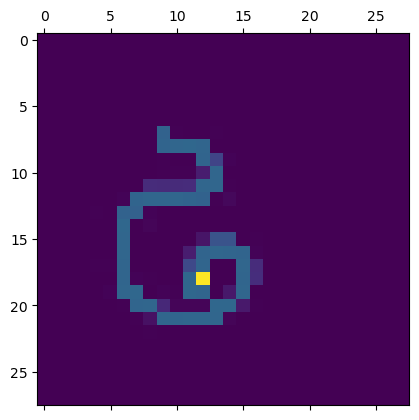

In [7]:
sbrain.nnet[char_id].show_receptive_field_id(104)

In [8]:
x = [0]
y = []
h = []
cumsum_x = 0
last_angle = 0
for nrn in sbrain.nnet[char_id].nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_curve":
        cumsum_x += nrn.neuron["meta"]["curve"]["nb_iteration"]
        x.append(cumsum_x)
        x.append(cumsum_x)
        print(nrn.neuron["_id"], ":", nrn.neuron["meta"]["curve"]["starting_point"], " *", nrn.neuron["meta"]["curve"]["nb_iteration"],"* ",cumsum_x,",",  nrn.neuron["meta"]["curve"]["angle"])
        last_angle = nrn.neuron["meta"]["curve"]["angle"]
        y.append(last_angle)
        y.append(last_angle)
        tmp_h = np.ones( nrn.neuron["meta"]["curve"]["nb_iteration"]) * last_angle
        h.extend(tmp_h)
y.append(last_angle)        
print("_______________________________________________________")
for nrn in sbrain.nnet[char_id].nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_line":
        print(nrn.neuron["_id"],  ":", nrn.neuron["meta"]["line"]["starting_point"] , " *", nrn.neuron["meta"]["line"]["nb_iteration"],"* ", )

58 : {'x': 9.0, 'y': 7.5045517458062925}  * 3 *  3 , -0.4665412018098977
63 : {'x': 12.0, 'y': 8.0}  * 6 *  9 , 0.5156498132011182
71 : {'x': 8.493806894404415, 'y': 11.0}  * 3 *  12 , 0.1199502400272397
76 : {'x': 7.0, 'y': 13.0}  * 4 *  16 , -0.513241733826589
81 : {'x': 6.0, 'y': 17.0}  * 5 *  21 , -0.4373020102223792
87 : {'x': 9.0, 'y': 20.0}  * 10 *  31 , -0.39491418598381556
98 : {'x': 13.500313705155467, 'y': 15.0}  * 3 *  34 , 0.10798974815893718
103 : {'x': 12.0, 'y': 18.56499257924946}  * 1 *  35 , 0.0
_______________________________________________________
59 : {'x': 9.0, 'y': 7.5045517458062925}  * 9 * 
64 : {'x': 12.0, 'y': 8.0}  * 3 * 
72 : {'x': 8.493806894404415, 'y': 11.0}  * 9 * 
99 : {'x': 13.500313705155467, 'y': 15.0}  * 3 * 
104 : {'x': 12.0, 'y': 18.56499257924946}  * 1 * 


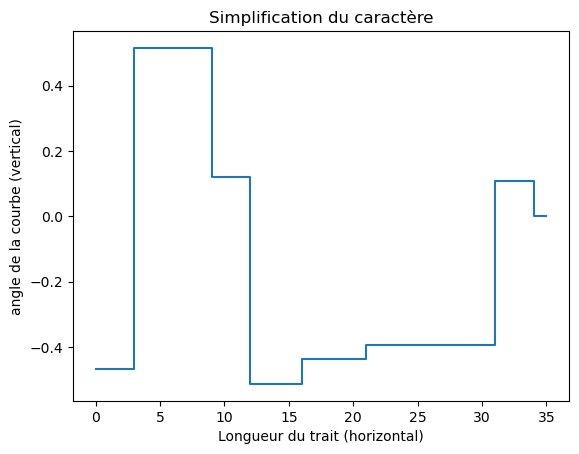

In [9]:
# tracer un graphique en escalier avec les points fournis
plt.plot(x, y, drawstyle='steps-post')

# ajouter des titres et des étiquettes d'axes
plt.title('Simplification du caractère')
plt.xlabel('Longueur du trait (horizontal)')
plt.ylabel('angle de la courbe (vertical)')

# afficher le graphique
plt.show()


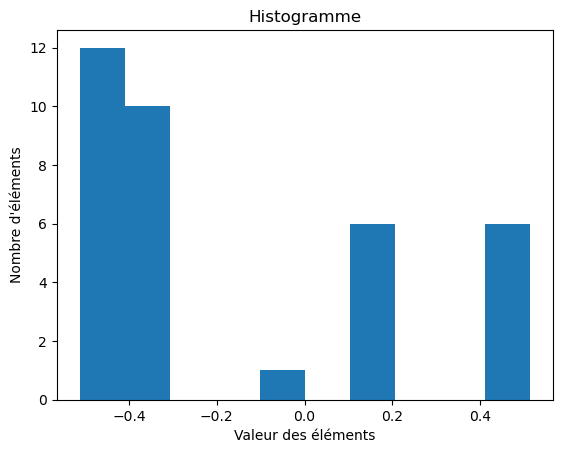

In [10]:
# tracer un histogramme avec les données fournies
plt.hist(h, bins=10)

# ajouter des titres et des étiquettes d'axes
plt.title('Histogramme')
plt.xlabel('Valeur des éléments')
plt.ylabel('Nombre d\'éléments')

# afficher le graphique
plt.show()


**nrn_drawer** : position de départ x 6 y 15
**nrn_drawer** : position intermédiaire x 6 y 17
**nrn_drawer** : position intermédiaire x 6 y 18
**nrn_drawer** : position intermédiaire x 7 y 19
**nrn_drawer** : position intermédiaire x 7 y 20
**nrn_drawer** : position intermédiaire x 8 y 20
**nrn_drawer** : position intermédiaire x 9 y 21
**nrn_drawer** : position intermédiaire x 10 y 21
**nrn_drawer** : position intermédiaire x 11 y 22
**nrn_drawer** : angle final: -0.15138697720744618
**nrn_drawer** : position finale x 11 y 22
**nrn_drawer** : dernier vector {'x': 0.9360022846185548, 'y': 0.351993924931733}


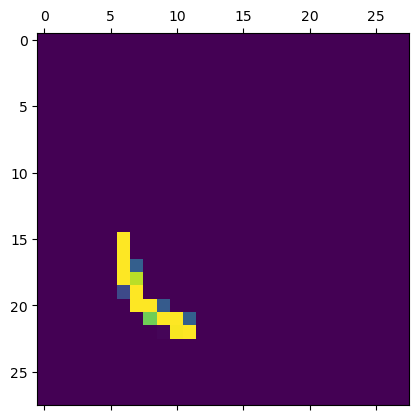

In [11]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 0, 
    "y" : 1
}
angle =  -0.15138697720744618
acc =  0
length = 9
start= {
    "x" : 6,
    "y" : 15
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

In [12]:
vector_1 = {
    "x": 0.4223896117376803,
    "y": -1.1496568147231787
}
vector_2 = {
    "x": -1.0062661425036992,
    "y": -1.0
}
self.nrn_tls.calc_angle(vector_1, vector_2)

-1.1406168716388418

In [13]:
vector={
    "x": 0.11179970673855372,
    "y": 1.1153802556657226
}
angle = 1.0146139224297328
self.nrn_tls.draw_rotate_vector(vector, angle)

{'x': -0.8882421433163732, 'y': 0.6838115120356595}

In [14]:
x = -0.9559481185106888
y = -1.0421915345635244
k = np.sqrt(np.power(x,2)+np.power(y,2))

print("norme du vecteur", k)
print("normalisation du vecteur")
print("x",x/k)
print("y",y/k)
print("Allongement de la norme à sqrt2")
print("x",np.sqrt(2)*x/k)
print("y",np.sqrt(2)*y/k)

norme du vecteur 1.4142135623730951
normalisation du vecteur
x -0.6759573970614294
y -0.7369407013850822
Allongement de la norme à sqrt2
x -0.955948118510689
y -1.0421915345635244


**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 7
**nrn_drawer** : position intermédiaire x 12 y 8
**nrn_drawer** : position intermédiaire x 12 y 9
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 12 y 11
**nrn_drawer** : position intermédiaire x 11 y 12
**nrn_drawer** : position intermédiaire x 10 y 12
**nrn_drawer** : position intermédiaire x 9 y 12
**nrn_drawer** : position intermédiaire x 8 y 12
**nrn_drawer** : position intermédiaire x 7 y 11
**nrn_drawer** : position intermédiaire x 7 y 10
**nrn_drawer** : position intermédiaire x 7 y 9
**nrn_drawer** : position intermédiaire x 7 y 8
**nrn_drawer** : angle final: 0.39
**nrn_drawer** : position finale x 7 y 8
**nrn_drawer** : dernier vector {'x': 0.3500373909938908, 'y': -0.9367357284240797}


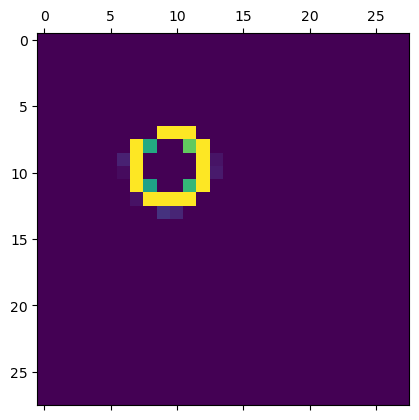

In [15]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1,
    "y" : 0
}
angle = 0.78/2
acc =  0
length = 14
start= {
    "x" : 9,
    "y" : 7
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

In [16]:
45/9

5.0

**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 8
**nrn_drawer** : position intermédiaire x 12 y 8
**nrn_drawer** : angle final: 2.0243190925315058
**nrn_drawer** : position finale x 12 y 8
**nrn_drawer** : dernier vector {'x': 1.003854360540015, 'y': 0.4988473834556587}


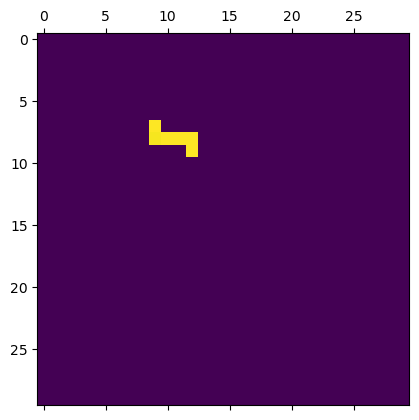

In [17]:
mtrx = np.zeros([30,30])
vector_1= {
    "x" : 0.506529652790199,
    "y" : 1
}
angle = -1.1019386507990419
acc =  1.5631288716652738
length = 3
start= {
    "x" : 9,
    "y" : 7
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)


In [18]:
int_counter = 0
for nrn in self.nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_matrix" and nrn.neuron["layer_id"]==2:
        # compte les neurones vision matrix
        int_counter += 1
print("Nombre de neurones vision matrix", int_counter)

Nombre de neurones vision matrix 36


**nrn_drawer** : position de départ x 12 y 8
**nrn_drawer** : position intermédiaire x 13 y 10
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 11 y 9
**nrn_drawer** : angle final: 1.2972384628321982
**nrn_drawer** : position finale x 11 y 9
**nrn_drawer** : dernier vector {'x': -0.3907409231662274, 'y': -1.0475311599008426}


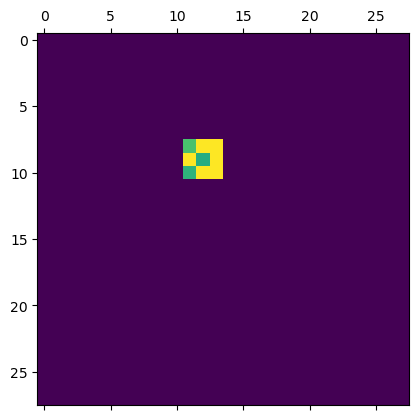

In [19]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1.0,
    "y" : 0.5
}
angle = 1.2972384628321982
acc =  0
length = 4
start= {
    "x" : 12,
    "y" : 8
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

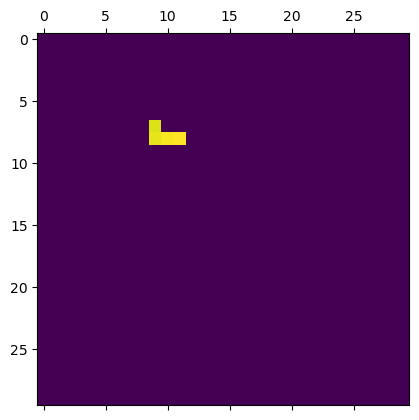

In [20]:
mtrx2 = np.zeros([30,30])
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(1, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(2, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(3, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(4, mtrx2)
mtrx2 = mtrx2/5
plt.matshow(mtrx2)

In [21]:
#dimension de la liste des neurones
len(sbrain.nnet[0].nrn_tls.lst_nrns)

105

In [22]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(2)
# mtrx = nrn3["meta"]["pixels_matrix"]
# plt.matshow(mtrx)


{'_id': 2,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.9633017778396606,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 9, 'y': 8}, 'matrix_width': 1}}

**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 9
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 13 y 11
**nrn_drawer** : position intermédiaire x 14 y 12
**nrn_drawer** : position intermédiaire x 15 y 13
**nrn_drawer** : position intermédiaire x 16 y 14
**nrn_drawer** : position intermédiaire x 17 y 15
**nrn_drawer** : angle final: 0
**nrn_drawer** : position finale x 17 y 15
**nrn_drawer** : dernier vector {'x': 1.0, 'y': 1.0}
save_pos [(10, 8), (12, 10), (11, 9), (15, 13), (17, 15), (14, 12), (16, 14), (9, 7), (13, 11)]


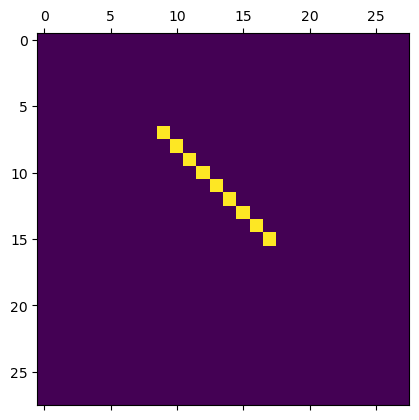

In [23]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1,
    "y" : 1
}
angle = 0
length = 8
start= {
    "x" : 9,
    "y" : 7
}
acc = 0

mtrx, angle, start, vector_1, save_pos = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)
print("save_pos", save_pos)

In [24]:
2*0.461190220866232

0.922380441732464

**nrn_drawer** : position de départ x 11 y 8
**nrn_drawer** : position intermédiaire x 13 y 9
**nrn_drawer** : angle final: 0.7243549945467616
**nrn_drawer** : position finale x 13 y 9
**nrn_drawer** : dernier vector {'x': 0.9021342216356463, 'y': 0.43145549730400484}
save_pos [(13, 9), (11, 8), (12, 8)]


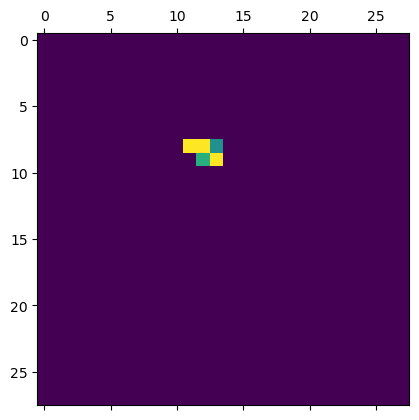

In [25]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 0.9486832980505135,
    "y" : 0.3162277660168378
}
angle = 0.1243549945467616
length = 2
start= {
    "x" : 11,
    "y" : 8
}
acc = 0.6

mtrx, angle, start, vector_1, save_pos = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)
print("save_pos", save_pos)

In [26]:
np.max(sbrain.nnet[0].episode[:,:,0])

1.0

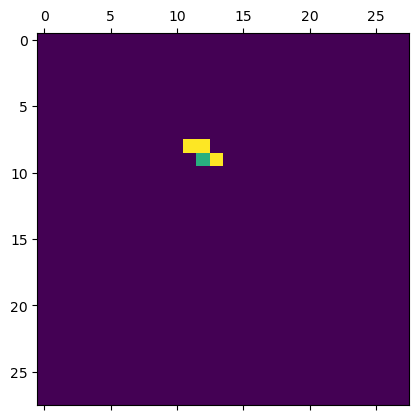

In [27]:
plt.matshow((sbrain.nnet[0].episode[:,:,0]>0) * mtrx)


In [28]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(39)

{'_id': 39,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.7545397877693176,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 12, 'y': 18}, 'matrix_width': 1}}

In [29]:
sbrain.nnet[0].nrn_tls.lst_nrns[0].neuron

{'_id': 1,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.9459211826324463,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 9, 'y': 7}, 'matrix_width': 1}}

In [30]:
sbrain.nnet[0].nb_nrn_pxls

56

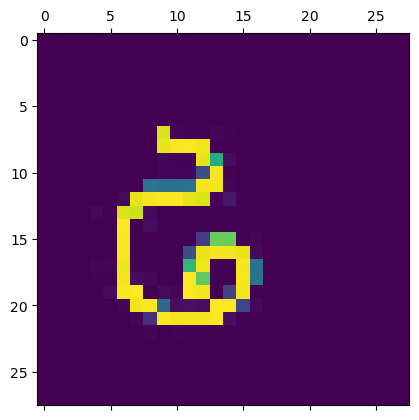

In [31]:
sbrain.nnet[0].show_receptive_field_id(40)

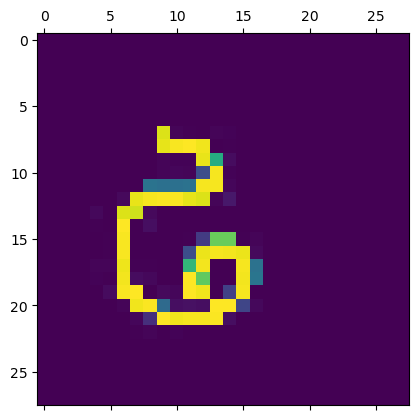

In [32]:
sbrain.nnet[0].show_receptive_field_id(52)

In [33]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(119)

''

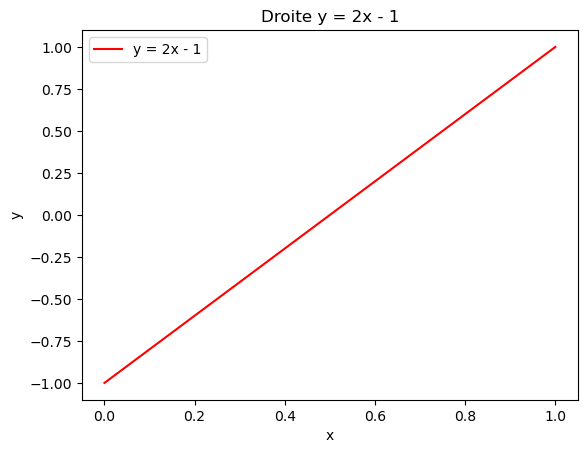

In [34]:
    # Définition des bornes pour x
    x_min = 0
    x_max = 1

    # Génération d'un tableau de valeurs pour x
    x = np.linspace(x_min, x_max)

    # Calcul des valeurs correspondantes pour y
    y = 2 * x - 1

    # Tracé de la droite
    plt.plot(x, y, 'r-', label='y = 2x - 1')

    # Configuration du graphique
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Droite y = 2x - 1')
    plt.legend()

    # Affichage du graphique
    plt.show()

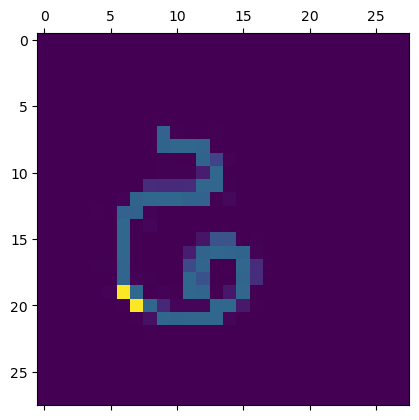

In [35]:
sbrain.nnet[0].show_receptive_field_id(83)

In [36]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(75)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(70)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

KeyError: 'glbl_prm'

In [ ]:
np_c_1 = np.array([-0.52573111, 0.85065081])
np_c_2 = np.array([-0.52573111, 0.85065081])

In [ ]:
np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))

In [ ]:
X = []
Y = []
u_x = []
u_y = []
nb = 0
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        nb += 1
        X.append(nrn2["meta"]["glbl_prm"]["cg"]["x"])
        Y.append(nrn2["meta"]["glbl_prm"]["cg"]["y"])
        u_x.append(nrn2["meta"]["glbl_prm"]["u_axis"]["x"])
        u_y.append(nrn2["meta"]["glbl_prm"]["u_axis"]["y"])
q = plt.quiver(X,Y,u_x,u_y)
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        x = nrn2["meta"]["glbl_prm"]["cg"]["x"]
        y = nrn2["meta"]["glbl_prm"]["cg"]["y"]
        plt.text(x,y, str(nrn2["_id"]))
        for key in nrn2["DbConnectivity"]['angles']:
            y += 0.5
            angle = nrn2["DbConnectivity"]['angles'][key]
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            if angle ==0:
                color = "green"
            elif angle < 0.1:
                color = "yellow"
            elif angle < 0.4:
                color = "orange"
            elif angle < 0.8:
                color = "red"
            else :
                color = "purple"
            plt.text(x,y, str(key),color=color)
            
print(nb)

In [ ]:
angles = []
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        for angle in nrn2["DbConnectivity"]['angles'].values():
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            angles.append(angle)
            
plt.hist(angles)

In [ ]:
def generate_comment(text):
    """
    Generates a formatted comment string.
    
    Parameters
    ----------
    text : str
        The text to be used in the comment.
    
    Returns
    -------
    str
        The formatted comment string.
    """
    comment = "".join(["* " + line for line in text.splitlines()])
    return "/**\n" + comment + "\n*/"


In [ ]:
generate_comment("This is a test")


In [ ]:
np.diff([0.46364760900080615, 0.0, 0.5563215839986531, 0.4331511312763392, 1.04497122052071, -0.4189906125041946, -0.36640755089325333, 0.0, 0.32175055439664196, 0.46364760900080565, 0.4189906125041958, 0.36640755089325294, 0.0, 0.0, 0.3217505543966417, 0.46364760900080615, 0.16964630722702223, 0.12435499454676169, 0.49139686162366436, 0.0, 0.32175055439664196, -1.10714871779409, 1.4781223517970488, 0.3866752767716308])


In [ ]:
plt.plot([-0.46364761,  0.55632158, -0.12317045,  0.61182009, -1.46396183,
        0.05258306,  0.36640755,  0.32175055,  0.14189705, -0.044657  ,
       -0.05258306, -0.36640755,  0.        ,  0.32175055,  0.14189705,
       -0.2940013 , -0.04529131,  0.36704187, -0.49139686,  0.32175055,
       -1.42889927,  2.58527107, -1.09144708])

In [ ]:
# Affiche un un graphique d'une matrice de données
def plot_matrix(point_data, mat_dim=(28, 28)):
    """
    Plots a matrix of data.
    
    Parameters
    ----------
    matrix : list
        The matrix of data to be plotted.
    mat_dim : tuple
        The dimensions of the matrix.
    """
    # Create an empty matrix of zeros of mat_dim dimensions
    matrix = np.zeros(mat_dim)
    # For each element in the matrix
    for point in point_data:
        # Set the value of the element to the value of the matrix
        matrix[point[1]][point[0]] +=1
    # Plot the matrix   
    plt.imshow(np.array(matrix).reshape(mat_dim), cmap='gray')
    plt.show()
plot_matrix([(11, 8), (9, 7), (9, 8), (10, 8)])

In [ ]:
# nrn3:96
plot_matrix([(11, 8), (12, 8), (10, 8), (12, 9)])

In [ ]:
# nrn3:97
plot_matrix([(11, 8), (13, 10), (12, 8), (12, 9)])

In [ ]:
#nrn3:98
plot_matrix([(12, 11), (13, 10), (13, 11), (12, 9)])


In [ ]:
# nrn3:99
plot_matrix([(13, 10), (11, 12), (12, 12), (12, 11), (13, 11)])

In [ ]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(99)

In [ ]:
sbrain.nnet[0].nrn_tls.calc_angle({'x': 0.9899494936611662, 'y': -0.14142135623730961},{"x":0, "y":1} )

In [ ]:
sbrain.nnet[0].nrn_tls.calc_angle({"x":0, "y":1}, {'x': 1, 'y': -0.3} )